## Value of an assist

This is the analysis for the article: 

In [641]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import time
import geopandas as gpd
import descartes
from PIL import Image
from statsmodels.stats.proportion import proportions_ztest
from matplotlib.patches import Circle, Rectangle, Arc
from matplotlib import pyplot
from scipy import stats


# The following data are obtained from https://github.com/hwchase17/sportvu

data13 = pd.read_csv("joined_shots_2013.csv")
data14 = pd.read_csv("joined_shots_2014.csv")

data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]

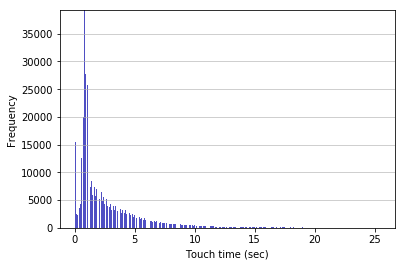

In [642]:
# histogram for touch time before the shot

n, bins, patches = plt.hist(x=data["TOUCH_TIME"], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Touch time (sec)')
plt.ylabel('Frequency')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.show()

We will explore the FG% for a specific zone for (potentially) assisted and unassisted shots. We will define assisted shot one where the touch time is less than 1 second (this might be restrictive; we will come back to it later). 

We will then calculate the league-average expected points per shot for assisted and non-assisted shots from each zone.

In [643]:
# create a new column that will say whether the shot was "assisted"

data['assisted'] = data.apply(lambda row: int((row.TOUCH_TIME <= 1.5) & (row.DRIBBLES < 2)), axis=1)

# create a new column that has the mapping between ZONE_BASIC and ZONE_AREA to the court zones in the shapefile 

d = np.array(["xxxxxxxxxxxxx"] * len(data))

d[data["SHOT_ZONE_BASIC"] == "Restricted Area"] = "Deep Paint"
d[data["SHOT_ZONE_BASIC"] == "In The Paint (Non-RA)"] = "BasketArea"
d[(data["SHOT_ZONE_BASIC"] == "Mid-Range") & (data["SHOT_ZONE_AREA"] == "Center(C)")] = "MidrangeSlot"
d[(data["SHOT_ZONE_BASIC"] == "Mid-Range") & (data["SHOT_ZONE_AREA"] == "Left Side(L)")] = "LeftBaseline"
d[(data["SHOT_ZONE_BASIC"] == "Mid-Range") & (data["SHOT_ZONE_AREA"] == "Right Side(R)")] = "RightBaseline"
d[(data["SHOT_ZONE_BASIC"] == "Above the Break 3") & (data["SHOT_ZONE_AREA"] == "Center(C)")] = "TopOfArc"
d[(data["SHOT_ZONE_BASIC"] == "Right Corner 3")] = "RightCorner3"
d[(data["SHOT_ZONE_BASIC"] == "Left Corner 3")] = "LeftCorner"
d[(data["SHOT_ZONE_BASIC"] == "Above the Break 3") & (data["SHOT_ZONE_AREA"] == "Right Side Center(RC)")] = "RightWing3"
d[(data["SHOT_ZONE_BASIC"] == "Above the Break 3") & (data["SHOT_ZONE_AREA"] == "Left Side Center(LC)")] = "LeftWing3"
d[(data["SHOT_ZONE_BASIC"] == "Mid-Range") & (data["SHOT_ZONE_AREA"] == "Right Side Center(RC)")] = "RightWing2"
d[(data["SHOT_ZONE_BASIC"] == "Mid-Range") & (data["SHOT_ZONE_AREA"] == "Left Side Center(LC)")] = "LeftWing2"

data['ZoneName'] = d
data = data[data["ZoneName"] != "xxxxxxxxxxxxx"]


In [644]:
# adjusted from Savvas Tjortjoglou code
# plotting function

def draw_court(ax=None, color='black', lw=2):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((25, 4), radius=7.5/10.0, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((23, 3), 4, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((17, 0), 160/10.0, 190/10.0, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, width=12ft, height=19ft
    inner_box = Rectangle((19, 0), 120/10.0, 190/10.0, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((25, 19), 12, 12, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((25, 19), 12, 12, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((25, 4.5), 8, 8.5, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((3, 0), 0, 14, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((47,0), 0, 14, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((25, 4.5), 47.5, 48.5, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc]

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax


Next we find the fraction of (potentially) assisted shots in every zone. This will give us some high-level idea on how these shots are generated. 

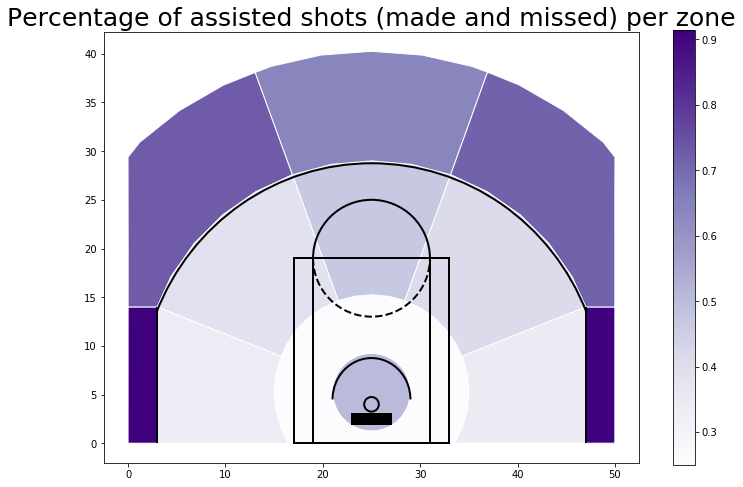

In [645]:
df = pd.DataFrame(columns=['ZoneName','assisted'])


for z, tmp in data.groupby('ZoneName'):
    df = df.append({'ZoneName' : z, 'assisted' : len(tmp[tmp["assisted"]==1])/float(len(tmp))},ignore_index=True)


court = gpd.read_file("CourtZones.shx")

court = court.merge(df,on="ZoneName")

fig, ax = plt.subplots(figsize  = (12, 8))

court.plot(column="assisted",cmap="Purples",legend=True,edgecolors="white",ax=ax)
ax.set_title("Percentage of assisted shots (made and missed) per zone", fontsize=25)
draw_court()

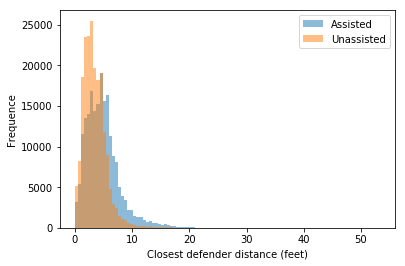

In [647]:
#histogram for the closest defender distance for assisted and unassisted shots
from matplotlib import pyplot
from scipy import stats

assisted = data[data['assisted'] == 1].CLOSE_DEF_DIST
unassisted = data[data['assisted'] == 0].CLOSE_DEF_DIST

bins = np.linspace(0, max(data["CLOSE_DEF_DIST"]), 100)

pyplot.hist(assisted, bins, alpha=0.5, label='Assisted')
pyplot.hist(unassisted, bins, alpha=0.5, label='Unassisted')
pyplot.xlabel("Closest defender distance (feet)")
pyplot.ylabel("Frequence")
pyplot.legend(loc='upper right')
pyplot.show()

# perform t-test and ks-test

tt, pt = stats.ttest_ind(assisted,unassisted)

tks, pks = stats.ks_2samp(assisted,unassisted)

In [648]:
#FG% for each zone with an assisted-non assisted split. 
#This will allow us to eventually see how much value an assist provides to each zone.

dffg = pd.DataFrame(columns=['ZoneName','assistedFG','unassistedFG','ppsDiffAss','pval']) # ppsDiffAss is the expected point per shot differential between assistes and unassisted shots

for z, tmp in data.groupby('ZoneName'):
    stats, pval = proportions_ztest(count = [len(tmp[(tmp["assisted"] == 1) & (tmp['SHOT_MADE_FLAG'] == 1)]),len(tmp[(tmp["assisted"] == 0) & (tmp['SHOT_MADE_FLAG'] == 1)])], nobs = [len(tmp[tmp['assisted']==1]), len(tmp[tmp['assisted']==0])])
    dffg = dffg.append({'ZoneName' : z, 'assistedFG' : len(tmp[(tmp["assisted"] == 1) & (tmp['SHOT_MADE_FLAG'] == 1)])/float(len(tmp[tmp['assisted']==1])), 'unassistedFG' : len(tmp[(tmp["assisted"]==0) & (tmp["SHOT_MADE_FLAG"] == 1)])/float(len(tmp[tmp['assisted']==0])), 'ppsDiffAss' : max(2,float(court[court['ZoneName'] == z].Range))*((len(tmp[(tmp["assisted"] == 1) & (tmp['SHOT_MADE_FLAG'] == 1)])/float(len(tmp[tmp['assisted']==1])))-(len(tmp[(tmp["assisted"] == 0) & (tmp['SHOT_MADE_FLAG'] == 1)])/float(len(tmp[tmp['assisted']==0])))), 'pval' : pval },ignore_index=True)
    
df1 = dffg[['ZoneName','assistedFG','unassistedFG','pval']]
df1.round(3)

,ZoneName,assistedFG,unassistedFG,pval
0,BasketArea,0.429,0.383,0.000
1,Deep Paint,0.676,0.536,0.000
2,LeftBaseline,0.426,0.380,0.000
3,LeftCorner,0.387,0.349,0.008
4,LeftWing2,0.405,0.386,0.018
5,LeftWing3,0.365,0.308,0.000
6,MidrangeSlot,0.417,0.388,0.000
7,RightBaseline,0.418,0.382,0.000
8,RightCorner3,0.396,0.329,0.000
9,RightWing2,0.401,0.385,0.042


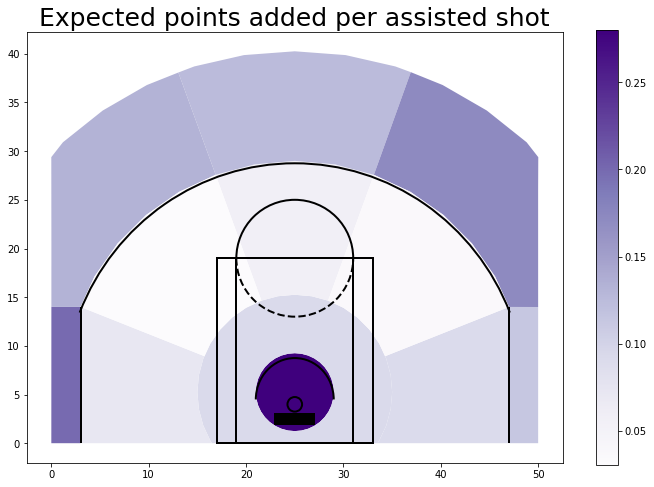

In [649]:
# expected points above unassisted shot 

court = court.merge(dffg,on="ZoneName")

fig, ax = plt.subplots(figsize = (12,8))

court.plot(ax=ax,column="ppsDiffAss",legend=True,cmap="Purples")
ax.set_title("Expected points added per assisted shot", fontsize=25)
draw_court()


In [657]:
# grouping data on a per player basis.

dffgp = pd.DataFrame(columns=['ZoneName','Player','assistedFG','unassistedFG'])

for z, tmpz in data.groupby('ZoneName'):
    for p, tmp in tmpz.groupby('PLAYER_NAME'):
        if (len(tmp[tmp['assisted'] == 1]) > 0) & (len(tmp[tmp['assisted'] == 0]) > 0) & (len(tmp)>50):
            dffgp = dffgp.append({'ZoneName' : z, 'Player' : p, 'assistedFG' : len(tmp[(tmp["assisted"] == 1) & (tmp['SHOT_MADE_FLAG'] == 1)])/float(len(tmp[tmp['assisted']==1])), 'unassistedFG' : len(tmp[(tmp["assisted"]==0) & (tmp["SHOT_MADE_FLAG"] == 1)])/float(len(tmp[tmp['assisted']==0]))},ignore_index=True)


In [658]:
dffgp.head()

,ZoneName,Player,assistedFG,unassistedFG
0,BasketArea,Aaron Brooks,0.181818,0.396135
1,BasketArea,Al Horford,0.421053,0.415584
2,BasketArea,Al Jefferson,0.560847,0.459839
3,BasketArea,Al-Farouq Aminu,0.277778,0.291667
4,BasketArea,Alan Anderson,0.285714,0.367647


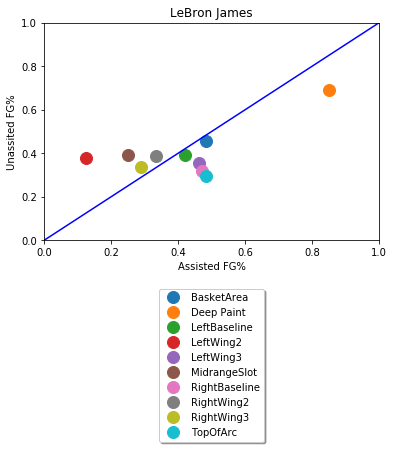

In [690]:
# you can plot individual players here

bins = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
groups = dffgp[dffgp['Player'] == "LeBron James"].groupby('ZoneName')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.assistedFG, group.unassistedFG, marker='o', linestyle='', ms=12, label=name)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True)
plt.ylim((0,1))
plt.xlim((0,1))

plt.plot(bins,bins,'b')
ax.set_xlabel('Assisted FG%')
ax.set_ylabel('Unassited FG%')
ax.set_title("LeBron James")
plt.show()